## Import Library

In [40]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [41]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pemisahan Dataset dan Augmentasi Data



In [42]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train'
val_dir = '/content/drive/MyDrive/PI/valid'
test_dir = '/content/drive/MyDrive/PI/test'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

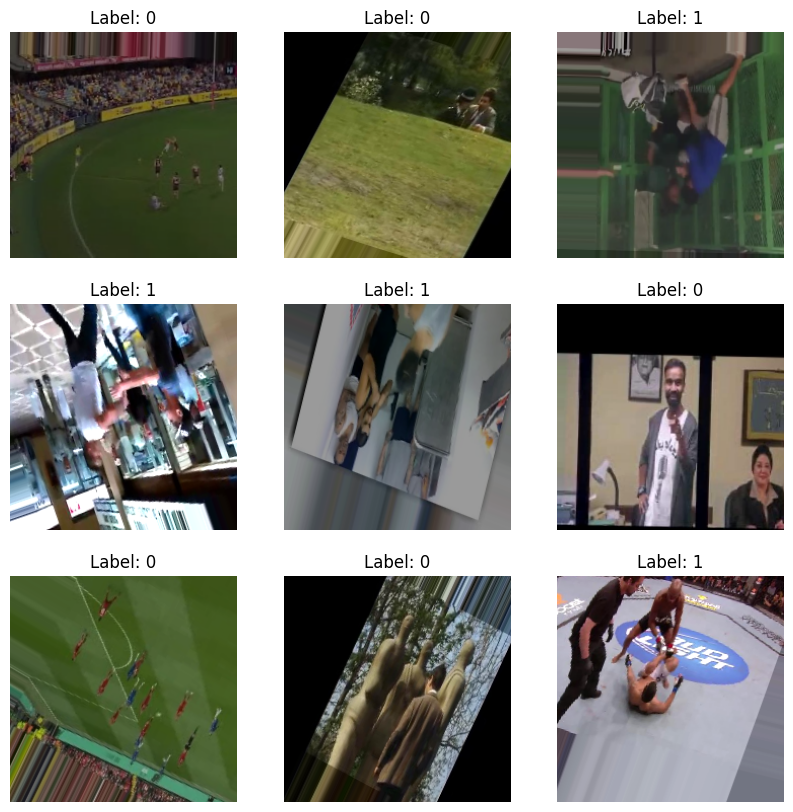

In [43]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [44]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Full Fine-Tune
for layer in base_model.layers:
    layer.trainable = True

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'NoMCLAHE_NoFreeze_0.0001.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 15,110,465 (57.64 MB)

 Non-trainable params: 1,536 (6.00 KB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [45]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.5581 - loss: 1.4828
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to NoMCLAHE_NoFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 49s 799ms/step - accuracy: 0.5577 - loss: 1.4828 - val_accuracy: 0.5000 - val_loss: 5.8299
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.5301 - loss: 1.4401
Epoch 2: val_accuracy improved from 0.50000 to 0.50227, saving model to NoMCLAHE_NoFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 713ms/step - accuracy: 0.5300 - loss: 1.4398 - val_accuracy: 0.5023 - val_loss: 1.9665
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.5125 - loss: 1.4546
Epoch 3: val_accuracy did not improve from 0.50227
49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 722ms/step - accuracy: 0.5124 - loss: 1.4545 - val_accuracy: 0.5000 - val_loss: 2.0026
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.5548 - loss: 1.3426
Epoch 4: val_accuracy did not improve from 0.50227
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 701ms/step - accuracy: 0.5545 - loss: 1.3428 - val_accuracy: 0.5000 - val_loss: 3.3388
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.5137 - loss: 1.4333
Epoch 5: val_accuracy improved from 0.50227 to 0.50455, saving model to NoMCLAHE_NoFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 706ms/step - accuracy: 0.5139 - loss: 1.4325 - val_accuracy: 0.5045 - val_loss: 1.4490
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.4915 - loss: 1.3699
Epoch 6: val_accuracy improved from 0.50455 to 0.51591, saving model to NoMCLAHE_NoFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 735ms/step - accuracy: 0.4917 - loss: 1.3698 - val_accuracy: 0.5159 - val_loss: 1.0851
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.5182 - loss: 1.3085
Epoch 7: val_accuracy did not improve from 0.51591
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 699ms/step - accuracy: 0.5183 - loss: 1.3087 - val_accuracy: 0.5000 - val_loss: 3.5304
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.4838 - loss: 1.3517
Epoch 8: val_accuracy did not improve from 0.51591
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 704ms/step - accuracy: 0.4842 - loss: 1.3509 - val_accuracy: 0.5000 - val_loss: 11.8440
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.4886 - loss: 1.3329
Epoch 9: val_accuracy did not improve from 0.51591
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 704ms/step - accuracy: 0.4888 - loss: 1.3331 - val_accuracy: 0.5000 - val_loss: 3.0898
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.5004 - loss: 1.3262
Epoch 10: val_accuracy did no

49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 717ms/step - accuracy: 0.5143 - loss: 1.2600 - val_accuracy: 0.5545 - val_loss: 1.0118
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.4985 - loss: 1.2253
Epoch 14: val_accuracy did not improve from 0.55455
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 699ms/step - accuracy: 0.4984 - loss: 1.2253 - val_accuracy: 0.5523 - val_loss: 0.9965
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.4947 - loss: 1.1770
Epoch 15: val_accuracy improved from 0.55455 to 0.55909, saving model to NoMCLAHE_NoFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 727ms/step - accuracy: 0.4947 - loss: 1.1771 - val_accuracy: 0.5591 - val_loss: 1.0013
Epoch 16/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.5416 - loss: 1.1930
Epoch 16: val_accuracy improved from 0.55909 to 0.57955, saving model to NoMCLAHE_NoFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 710ms/step - accuracy: 0.5413 - loss: 1.1931 - val_accuracy: 0.5795 - val_loss: 0.9867
Epoch 17/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.5015 - loss: 1.2051
Epoch 17: val_accuracy improved from 0.57955 to 0.59091, saving model to NoMCLAHE_NoFreeze_0.0001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 710ms/step - accuracy: 0.5017 - loss: 1.2049 - val_accuracy: 0.5909 - val_loss: 1.0882
Epoch 18/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.5441 - loss: 1.1593
Epoch 18: val_accuracy did not improve from 0.59091
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 716ms/step - accuracy: 0.5443 - loss: 1.1589 - val_accuracy: 0.5000 - val_loss: 2.8095
Epoch 19/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.5677 - loss: 1.0952
Epoch 19: val_accuracy did not improve from 0.59091
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 701ms/step - accuracy: 0.5680 - loss: 1.0947 - val_accuracy: 0.5000 - val_loss: 3.6174
Epoch 20/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.5915 - loss: 1.0978
Epoch 20: val_accuracy did not improve from 0.59091
49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 721ms/step - accuracy: 0.5916 - loss: 1.0972 - val_accuracy: 0.5568 - val_loss: 0.9170
Epoch 21/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.6386 - loss: 0.9678
Epoch 21: val_accuracy i

49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 717ms/step - accuracy: 0.6386 - loss: 0.9681 - val_accuracy: 0.6250 - val_loss: 1.3730
Epoch 22/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.5885 - loss: 1.0669
Epoch 22: val_accuracy did not improve from 0.62500
49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 723ms/step - accuracy: 0.5881 - loss: 1.0673 - val_accuracy: 0.5000 - val_loss: 2.1624
Epoch 23/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.6107 - loss: 0.9954
Epoch 23: val_accuracy did not improve from 0.62500
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 707ms/step - accuracy: 0.6108 - loss: 0.9962 - val_accuracy: 0.5000 - val_loss: 4.2416
Epoch 24/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.5345 - loss: 1.1124
Epoch 24: val_accuracy did not improve from 0.62500
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 711ms/step - accuracy: 0.5345 - loss: 1.1123 - val_accuracy: 0.4182 - val_loss: 1.8142
Epoch 25/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.4941 - loss: 1.1401
Epoch 25: val_accuracy d

## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.8013 - loss: 1.1838
Validation Loss: 2.683769941329956
Validation Accuracy: 0.5


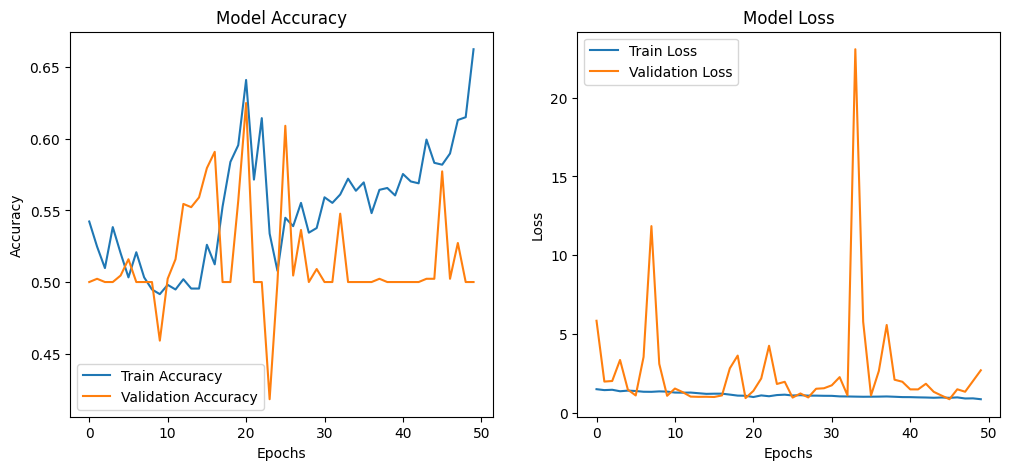

In [46]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [47]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('NoMCLAHE_NoFreeze_0.0001.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.8018 - loss: 0.8722
Test Accuracy : 60.36%
Test Loss     : 1.425


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step


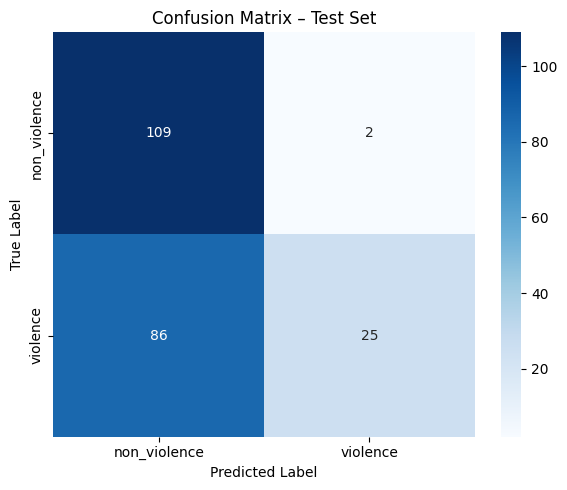


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.56      0.98      0.71       111
    violence       0.93      0.23      0.36       111

    accuracy                           0.60       222
   macro avg       0.74      0.60      0.54       222
weighted avg       0.74      0.60      0.54       222



In [48]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))